# LSTM recipe generator training

Note: This notebook is desinged to run with GPU runtime.

Install Huggingface libraries to use the pretrained tokenizer.

In [1]:
pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Install Google Translate library to convert generated texts to other languages.

In [2]:
pip install -q googletrans==4.0.0-rc1

Import modules and set random seeds.

In [3]:
import os, random
os.environ['PYTHONHASHSEED'] = str(20230629)
random.seed(20240329)

import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame

import tensorflow as tf
from tensorflow.keras import layers, models
from googletrans import Translator

np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

Download the pretrained tokenizer and check the vacabulary size.

In [4]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
VOCAB_SIZE = AutoConfig.from_pretrained(model_ckpt).vocab_size

print('Vocabulary size: {}'.format(VOCAB_SIZE))

Vocabulary size: 30522


Mount the google drive and load the trained model.

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

lstm_model = models.load_model('/content/gdrive/My Drive/LSTM_recipe_generator.hd5')
lstm_model.summary()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Model: "LSTM_next_word_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_embedding (Embedding)  (None, None, 512)         15627264  
                                                                 
 LSTM_cell (LSTM)            (None, None, 512)         2099200   
                                                                 
 softmax (Dense)             (None, None, 30522)       15657786  
                                                                 
Total params: 33,384,250
Trainable params: 33,384,250
Non-trainable params: 0
_________________________________________________________________


Define a function to generate new texts.

In [6]:
def sample_from(probs, temp):
    probs = probs ** (1 / temp)
    probs = probs / np.sum(probs)
    return np.random.choice(len(probs), p=probs), probs


def gen_text(prompt, temp=0.1, lang='en'):
    tokenized_text = tokenizer(prompt)
    input_ids = np.array(tokenized_text['input_ids'])[:-1]

    for i in range(256):
        if i % 100 == 0 and i > 0:
            print('')
        probs = lstm_model.predict(np.array([input_ids]), verbose=0)[0][-1]
        next_token, _ = sample_from(probs, temp)
        next_word = tokenizer.convert_ids_to_tokens([next_token])[0]
        if next_word == '[SEP]':
            break
        print('.', end='')
        input_ids = np.append(input_ids, next_token)

    answer = tokenizer.convert_tokens_to_string(
        tokenizer.convert_ids_to_tokens(input_ids[1:])
    )
    print('')

    if lang == 'en':
        return answer, answer

    translator = Translator()
    translated = translator.translate(answer, dest=lang);
    return answer, translated.text

Define a function to show top 10 tokens following the input text.

In [7]:
def top_k(prompt, temp=0.1):
    tokenized_text = tokenizer(prompt)
    input_ids = np.array(tokenized_text['input_ids'])[:-1]

    probs = lstm_model.predict(np.array([input_ids]), verbose=0)[0][-1]
    _, probs = sample_from(probs, temp)
    probs = list(zip(probs, range(len(probs))))
    top_k = sorted(probs, reverse=True)[:10]
    probs = [p for p, _ in top_k]
    labels = [tokenizer.convert_ids_to_tokens([token])[0] for _, token in top_k]

    n = len(probs)
    fig = plt.figure(figsize=(6, 2))
    subplot = fig.add_subplot(1, 1, 1)
    subplot.set_xticks(range(n))
    subplot.set_xlim([-0.5, n - 0.5])
    subplot.set_ylim([0, 1])
    subplot.set_xticklabels(labels)
    subplot.set_title(prompt, fontsize=11)
    _ = subplot.bar(range(n), probs, align='center')

Generate some sample texts.

In [8]:
gen_text('Recipe for beef', temp=1.0, lang='ja')

....................................................................................................
................................................


('recipe for beef bouillon appetizers : preheat oven to 350 degrees f ( 175 degrees c ). in a large bowl, mix together the nutmeg, salt and ground ginger. set aside. stir butter into the butter mixture, one at a time until thin. stir together the pumpkin pieces. mix in heavy cream. stir in place noodles, one at a time, and continue cooking until the mixture comes to a simmer. whisk together 1 tablespoon of the white wine, 1 teaspoon salt, and sugar into medium pot ; pour over pasta over the pork. cook 1 hour, stirring occasionally, until just comes. remove noodles from the sheet to 2 plates. serve hot, or black olives.',
 'ビーフブイヨン前菜のレシピ：オーブンを350度F（175度C）に予熱します。大きなボウルに、ナツメグ、塩、挽いた生ingerを混ぜます。脇に置いてください。バターの混合物にバターをかき混ぜます。薄くなるまで一度に1つずつ。カボチャの部分を一緒にかき混ぜます。ヘビークリームを混ぜます。麺を一度に1つずつかき混ぜ、混合物が煮るまで調理を続けます。大さじ1杯の白ワイン、小さじ1杯、砂糖を中鍋に泡立てます。豚肉の上にパスタを注ぎます。時々かき混ぜながら、ちょうど来るまで1時間調理します。シートから2つのプレートに麺を取り外します。熱い、またはブラックオリーブを提供します。')

In [9]:
gen_text('Recipe for beef', temp=0.5, lang='ja')

....................................................................................................
....................................................................................................
........................................................


('recipe for beef and noodles soup : cook and stir the rice in a large pot over medium heat until the onions are soft. add the onion and garlic. cook and stir until the onion is soft and translucent, about 5 minutes. stir in the tomatoes, tomato paste, and red pepper flakes. cook and stir until the vegetables are tender, about 5 minutes. pour the sauce over the chicken, and stir in the tomato paste, and bring to a boil. reduce heat to medium - low, cover, and simmer for 20 minutes. stir in the tomato sauce, then remove from heat. pour the sauce over the chicken and vegetables. pour the soup into the pot. bring to a boil. reduce heat to low, cover, and simmer until the rice is tender, about 10 minutes. preheat oven to 350 degrees f ( 175 degrees c ). in a medium bowl, mix together the remaining flour, baking powder, salt and baking soda. mix in the flour and 1 / 2 teaspoon of the remaining 1 / 2 cup of butter. season with salt and pepper. stir in the remaining 1 / 2 cup of flour and 1 /

In [10]:
gen_text('Recipe for beef', temp=0.1, lang='ja')

....................................................................................................
....................................................................................................
........................................................


('recipe for beef and cheese soup : in a large pot over medium heat, combine the ground beef, onion, and celery. cook and stir until the onion has softened and turned translucent, about 5 minutes. stir in the tomatoes, tomato paste, and red pepper flakes. cook and stir until the vegetables are tender, about 5 minutes. stir in the tomatoes, tomato paste, and red pepper flakes. bring to a boil, then reduce heat to medium - low, and simmer for 10 minutes. stir in the tomatoes, tomato sauce, and tomato paste. bring to a boil, and cook until the vegetables are tender, about 5 minutes. stir in the tomatoes, and cook until the vegetables are tender, about 5 minutes. stir in the tomatoes, and cook until the sauce is reduced by half, about 5 minutes. stir in the tomatoes, tomato sauce, and tomato paste. simmer for 10 minutes. stir in the tomatoes, tomato sauce, and red pepper flakes. simmer for 10 minutes. stir in the remaining 1 / 2 cup of the soup. cook and stir until the sauce is thickened, 

In [11]:
gen_text('Recipe for apple', temp=1.0, lang='ja')

....................................................................................................
....................................................................................................
........................


('recipe for apple pound cake ii : preheat oven to 400 degrees f ( 200 degrees c ). bundt cake liners with cooking spray. cream butter together in a saucepan or wok over high heat, stirring frequently. drizzle with butter or butter mixture. cover with hot water and cook, stirring often, until butter is softened and turned golden brown, 5 to 10 minutes. transfer mixture to a saucepan and whisk together the milk, shallow powder, and salt ; continue to cook 10 minutes. add cream cheese and cook until mixture is browned to the bottom of the cookies and bottom well. continue cooking mixing on low speed until meat and dark brown on each side,. pour creamed mixture over and heat until butter is melted, 3 to 5 minutes. transfer hush puppies to a large baking pan and top with 1 / 4 cup cheese and let desired type. you will need on veies. bake in the preheated oven until biscuits are well set, 25 to 30 minutes more. cool bread before icing pan without separating. refrigerate if using each icing.

In [12]:
gen_text('Recipe for apple', temp=0.5, lang='ja')

....................................................................................................
..........................................


('recipe for apple crumb bars : preheat oven to 350 degrees f ( 175 degrees c ). grease and flour a 9x5 - inch loaf pan. sift the flour, sugar, baking soda, baking powder, salt, and baking soda together in a bowl. in a separate bowl, mix together the flour, baking soda, salt, cinnamon, nutmeg, and nutmeg. stir in the walnuts. drop by teaspoonfuls of batter onto the prepared baking sheets. bake in the preheated oven until a toothpick inserted into the center comes out clean, about 25 minutes. let cool in pan for 10 minutes. remove from the oven and let cool completely.',
 'リンゴのパン粉バーのレシピ：オーブンを350度F（175度C）に予熱します。グリースと小麦粉A 9x5 -インチローフパン。小麦粉、砂糖、重曹、ベーキングパウダー、塩、重曹をボウルに入れます。別のボウルに、小麦粉、重曹、塩、シナモン、ナツメグ、ナツメグを混ぜます。クルミをかき混ぜます。準備したベーキングシートに小さじ1杯のバッターを落とします。中央に挿入されたつまようじがきれいになるまで、予熱したオーブンで焼きます。約25分。パンを10分間冷まします。オーブンから取り出し、完全に冷まします。')

In [13]:
gen_text('Recipe for apple', temp=0.1, lang='ja')

....................................................................................................
.....


('recipe for apple and cheesecake : preheat oven to 350 degrees f ( 175 degrees c ). grease a 9x13 - inch baking dish. combine the flour, baking powder, salt, and baking soda in a bowl. stir in the eggs, and stir until well blended. pour the mixture into the prepared pan. bake in the preheated oven until a toothpick inserted into the center comes out clean, about 20 minutes. cool in the pan for 10 minutes before removing to cool completely on a wire rack.',
 'リンゴとチーズケーキのレシピ：オーブンを350度F（175度C）に予熱します。9x13 -インチベーキング皿にグリースを塗ります。小麦粉、ベーキングパウダー、塩、重曹をボウルに混ぜます。卵をかき混ぜ、よく混ざるまでかき混ぜます。混合物を準備したパンに注ぎます。中央に挿入されたつまようじがきれいになるまで、予熱したオーブンで焼きます。約20分です。ワイヤーラックで完全に冷却するために取り外す前に、パンで10分間冷却します。')

Show top 10 tokens for a sample text.

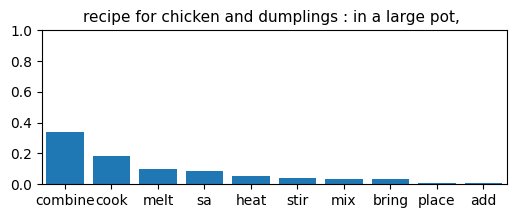

In [14]:
top_k('recipe for chicken and dumplings : in a large pot, ', temp=1.0)

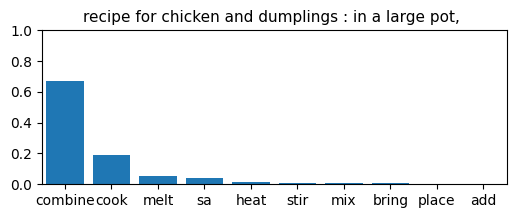

In [15]:
top_k('recipe for chicken and dumplings : in a large pot, ', temp=0.5)

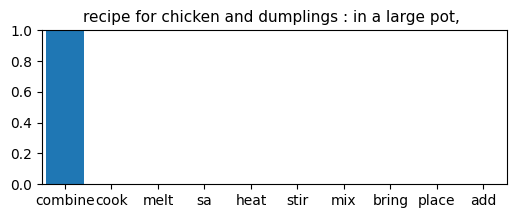

In [16]:
top_k('recipe for chicken and dumplings : in a large pot, ', temp=0.1)